# Trabalho final de Processamento de Imagens - BCC FURB 2024/1
### Alunos: Luan Lavandoski Guarnieri, Maria Eduarda Krutzsch

## Tema: Classificação de incêndios de imagens de satélite utilizando CNN
### Dataset: https://www.kaggle.com/datasets/abdelghaniaaba/wildfire-prediction-dataset/data

### Declarar funções que serão posteriormente usadas e importações

Carregando dataset/train - wildfire
Carregando dataset/train - nowildfire
Carregando dataset/valid - wildfire
Carregando dataset/valid - nowildfire
Carregando dataset/test - wildfire
Carregando dataset/test - nowildfire
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization_3 (Bat  (None, 16, 16, 64)        256       
 chNormalization)                                                
                                

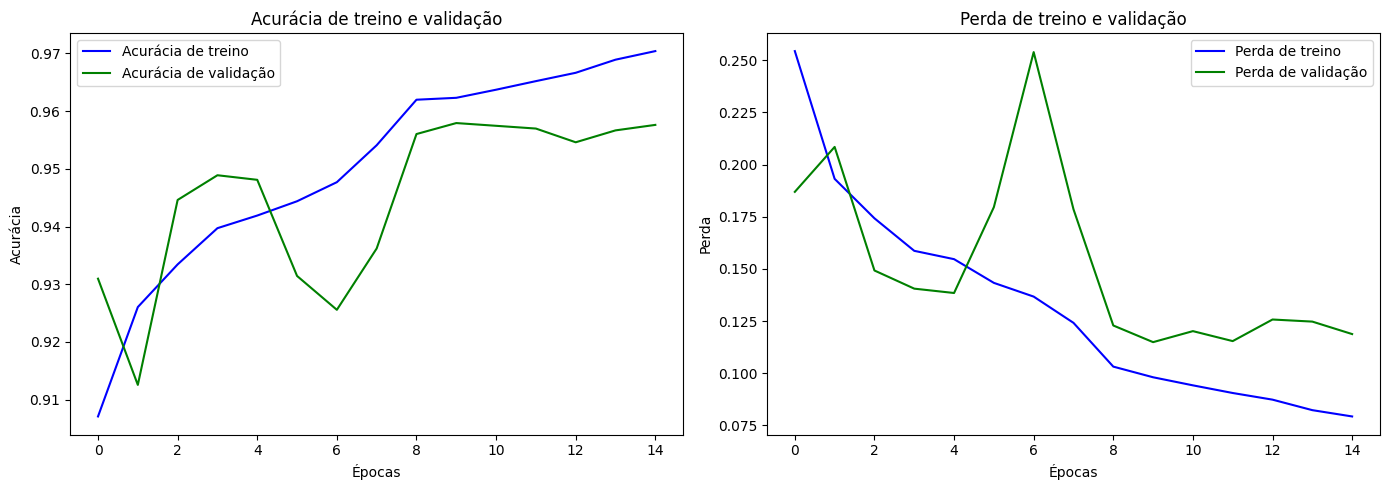

1/1 [==============================] - 0s 38ms/step


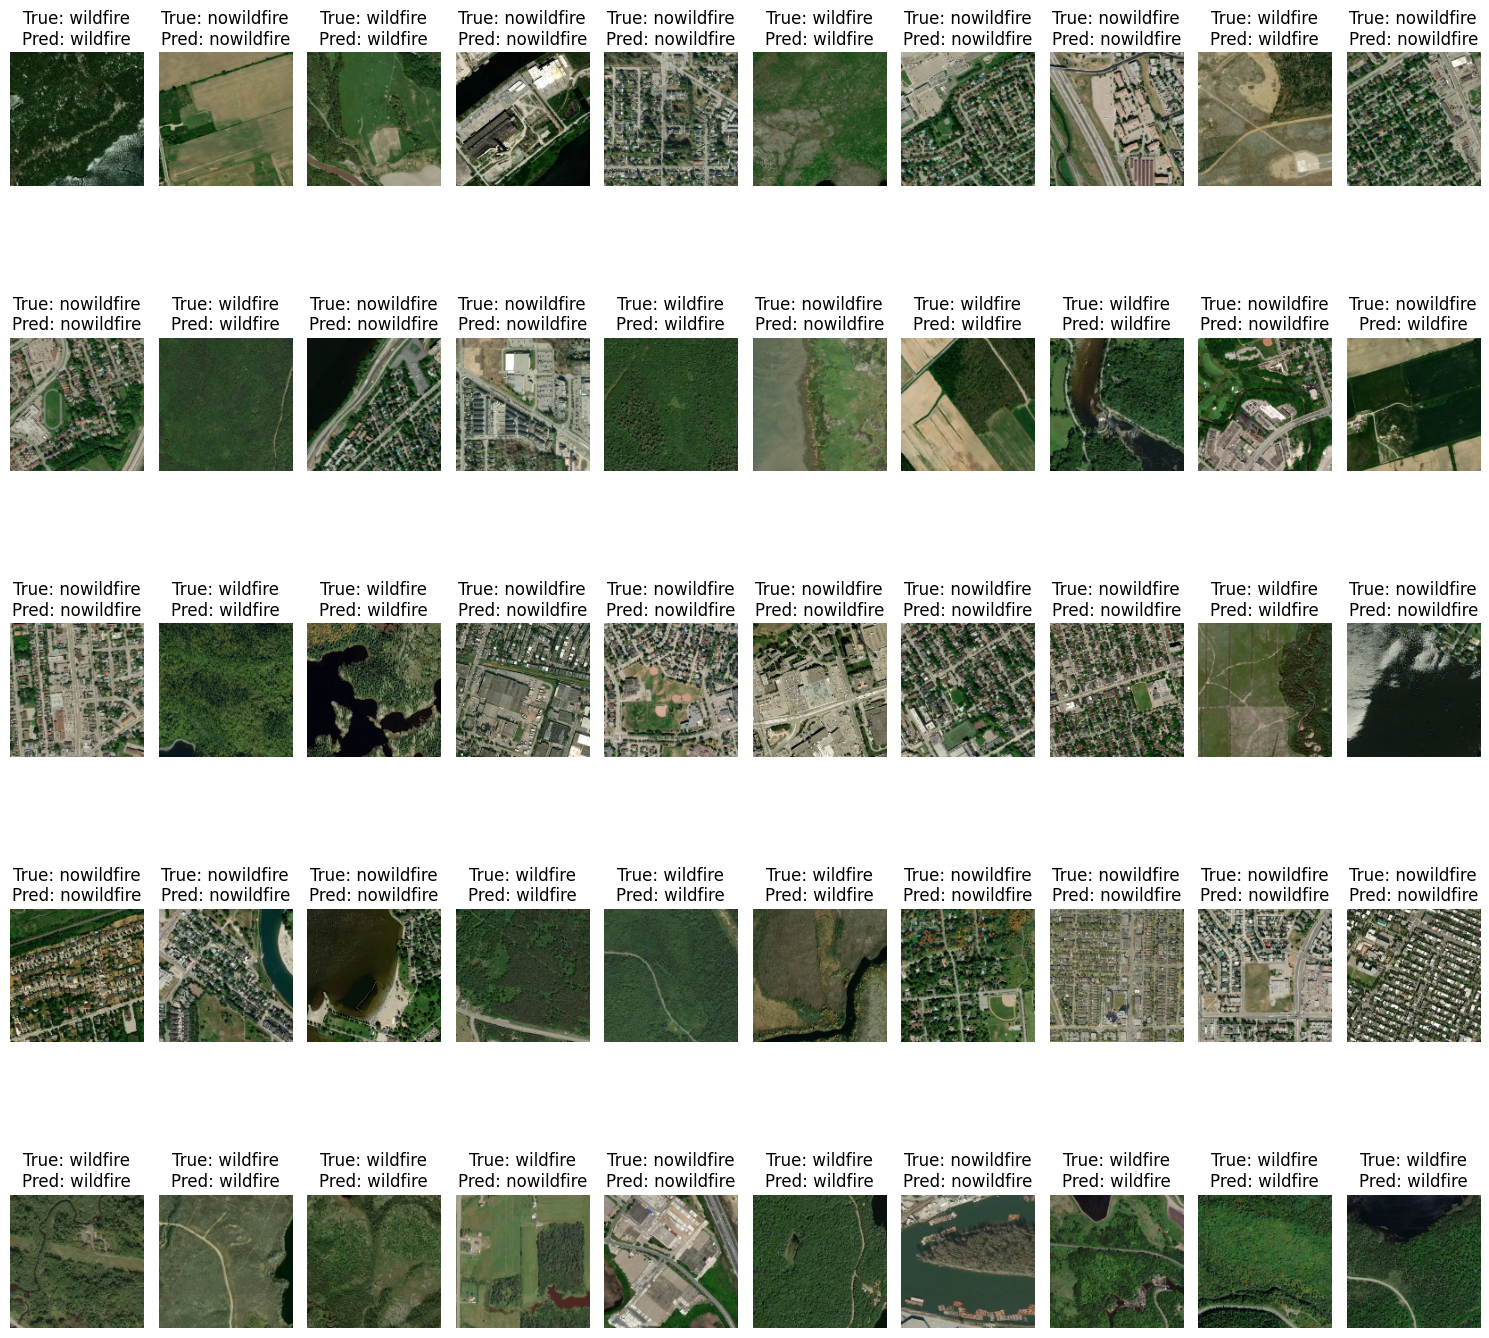

48/50 imagens classificadas corretamente
Acurácia: 96.00%
190/190 [==============================] - 16s 83ms/step


<Figure size 800x600 with 0 Axes>

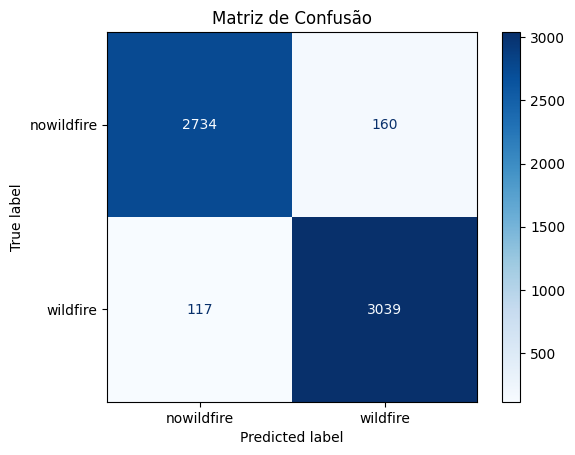

197/197 [==============================] - 13s 67ms/step


<Figure size 800x600 with 0 Axes>

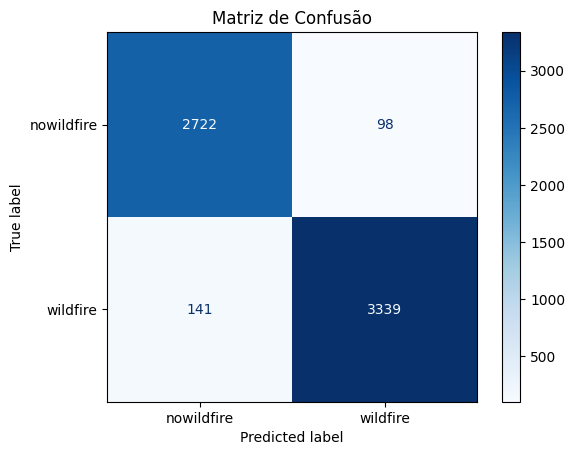

In [4]:
"""
# baixar o dataset no drive
!apt-get install p7zip-full
url = 'https://furb-my.sharepoint.com/:u:/g/personal/lguarnieri_furb_br/EZR0EMIIGG9BpqXh0rWSFLoB2K6n6ykQ6XJXegCSqDP6og?e=shFuRy&download=1'
!wget "{url}" -O dataset.7z
!p7zip -d dataset.7z -o/content/dataset
"""

import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

label_encoder = LabelEncoder()

# função para carregar imagens do dataset de validação e treinamento
def load_images(dataset_dir, dataset, labels):
    # para cada pasta dentro do diretório
    for direct in os.listdir(dataset_dir):
        print("Carregando {} - {}".format(dataset_dir, direct))
        # para cada arquivo dentro da pasta
        for filename in os.listdir(os.path.join(dataset_dir, direct)):
            img_path = os.path.join(dataset_dir, direct, filename)
            image = cv2.imread(img_path)
            # redimensionar para 32x32 (treinamento mais rápido)
            image = cv2.resize(image, (32, 32))
            image = np.array(image)
            # divide por 255 para normalizar os valores dos pixels
            image = image / 255
            dataset.append(image)
            labels.append(direct)

# função que carrega o dataset de teste e armazena o caminho dela
def load_img_classificar(test_dataset_dir, test_dataset, test_labels, test_image_paths):
    for direct in os.listdir(test_dataset_dir):
        print("Carregando {} - {}".format(test_dataset_dir, direct))
        for filename in os.listdir(os.path.join(test_dataset_dir, direct)):
            img_path = os.path.join(test_dataset_dir, direct, filename)
            image = cv2.imread(img_path)
            if image is None:
                continue
            image_resized = cv2.resize(image, (32, 32)) / 255.0
            test_dataset.append(image_resized)
            test_labels.append(direct)
            test_image_paths.append(img_path)

# função que plota os dados de acurácia do treino e do validação, e a perda de ambos também
def plot_dados(history):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Acurácia
    axs[0].plot(history.history['accuracy'], label='Acurácia de treino', color='blue')
    axs[0].plot(history.history['val_accuracy'], label='Acurácia de validação', color='green')
    axs[0].set_title('Acurácia de treino e validação')
    axs[0].set_xlabel('Épocas')
    axs[0].set_ylabel('Acurácia')
    axs[0].legend()

    # Perda
    axs[1].plot(history.history['loss'], label='Perda de treino', color='blue')
    axs[1].plot(history.history['val_loss'], label='Perda de validação', color='green')
    axs[1].set_title('Perda de treino e validação')
    axs[1].set_xlabel('Épocas')
    axs[1].set_ylabel('Perda')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# Função para plotar imagens aleatórias com suas classificações originais e predições
def plot_imgs_classificadas(test_image_paths, test_dataset, test_labels, model, num_images=50):
    label_encoder.fit(test_labels)

    correct_predictions = 0

    # Plotar as imagens em um grid
    plt.figure(figsize=(15, 15))

    for i in range(num_images):
        idx = random.randint(0, len(test_image_paths) - 1)
        img_path = test_image_paths[idx]
        image = cv2.imread(img_path)
        if image is None:
            continue

        image_resized = cv2.resize(image, (150, 150))
        prediction = model.predict(np.expand_dims(test_dataset[idx], axis=0))
        predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])[0]
        true_label = test_labels[idx]

        if predicted_label == true_label:
            correct_predictions += 1

        # Converte a imagem para RGB
        image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)

        # Adiciona a imagem ao plot
        plt.subplot(5, 10, i+1)
        plt.imshow(image_rgb)
        plt.title(f'True: {true_label}\nPred: {predicted_label}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    accuracy = correct_predictions / num_images
    print(f'{correct_predictions}/{num_images} imagens classificadas corretamente\nAcurácia: {accuracy:.2%}')


# função para calcular e exibir a matriz de confusão
def plot_confusion_matrix(model, X_test, Y_test, label_encoder):
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = np.argmax(Y_test, axis=1)

    cm = confusion_matrix(y_true, y_pred)

    # exibir a matriz de confusão
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    plt.figure(figsize=(8, 6))
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Matriz de Confusão')
    plt.show()

# ============================= Carregar datasets =============================
# carrega o dataset de treinamento
train_dataset_dir = 'dataset/train'
train_dataset = []
train_labels = []
load_images(train_dataset_dir, train_dataset, train_labels)

# carrega o dataset de validação
validation_dataset_dir = 'dataset/valid'
validation_dataset = []
validation_labels = []
load_images(validation_dataset_dir, validation_dataset, validation_labels)

# carrega o dataset de teste
test_dataset_dir = 'dataset/test'
test_dataset = []
test_labels = []
test_image_paths = []
load_img_classificar(test_dataset_dir, test_dataset, test_labels, test_image_paths)

# ============================= Aplicar label encoder =============================

# aplica o label encoder e transforma em labels categóricas
label = label_encoder.fit_transform(train_labels)
train_labels_cat = to_categorical(label)

label = label_encoder.fit_transform(validation_labels)
validation_labels_cat = to_categorical(label)

train_dataset = np.array(train_dataset)
validation_dataset = np.array(validation_dataset)

# ============================= Divisão dos dados =============================

train_dataset, train_labels_cat = shuffle(train_dataset, train_labels_cat)
validation_dataset, validation_labels_cat = shuffle(validation_dataset, validation_labels_cat)

X_train, X_test, Y_train, Y_test = train_test_split(train_dataset, train_labels_cat, test_size=0.2)

Y_train = np.array([np.array(i) for i in Y_train])
Y_test = np.array([np.array(i) for i in Y_test])
validation_labels_cat = np.array([np.array(i) for i in validation_labels_cat])

# ============================= Construir o modelo =============================

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.summary()

# ============================= Treinamento do modelo =============================

# callbacks para redução de learning rate e parada antecipada
# serve para controlar o overfitting
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, Y_train,
                    validation_data=(validation_dataset, validation_labels_cat),
                    batch_size=32,
                    epochs=15,
                    callbacks=[reduce_lr, early_stopping])

# ============================= Resultados =============================

# avaliar o modelo no conjunto de teste
test_loss, test_accuracy = model.evaluate(np.array(test_dataset), to_categorical(label_encoder.transform(test_labels)), verbose=2)
print(f'Acurácia no conjunto de teste: {test_accuracy:.4f}')
print(f'Perda no conjunto de teste: {test_loss:.4f}')

# plota os dados
plot_dados(history)

# faz a predição e plota as imagens com as classificações
plot_imgs_classificadas(test_image_paths, test_dataset, test_labels, model, num_images=50)

# exibe a matriz de confusão do conjunto de teste
plot_confusion_matrix(model, X_test, Y_test, label_encoder)
# exibe a matriz de confusão do conjunto do dataset de teste
plot_confusion_matrix(model, np.array(test_dataset), to_categorical(label_encoder.transform(test_labels)), label_encoder)


